# Condiciones de aceptabilidad de modelos con polítropa I

Este cuaderno muestra gráficamente, para distintos valores de $\sigma$ ($= \frac{P_c}{\rho_c}$), el cumplimiento (o no) de condiciones de aceptabilidad física en esferas anisótropas relativistas con ecuación de estado polítropa I
\begin{equation}
    P = \kappa \hat{\rho}^{1+\frac{1}{n}}
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import integrate
from scipy.integrate import solve_ivp

In [2]:
plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})
params = {'text.latex.preamble' : [r'\usepackage{amsmath}']}
plt.rcParams.update(params)
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

# Modelado de objetos compactos

## Ecuaciones de estructura

Las ecuaciones de estructura son el resultado de manipular las ecuaciones de campo de Einstein para una métrica y un tensor de energía dado, y son las ecuaciones que hay que resolver para modelar objetos compactos. En el caso de configuraciones estáticas con simetría esférica y anisotropía en la presión, las ecuaciones de estructura consisten en

\begin{eqnarray}
P^{\prime} &=& - \left(\rho + P \right) \frac{m + 4 \pi r^{3} P}{r(r - 2m)} + \frac{2}{r} \left(P_{\perp} - P \right)  \label{EqHid} \tag{1} \\
m^{\prime} &=& 4 \pi r^{2} \rho \label{MasDif} \tag{2}
\end{eqnarray}
donde $\rho$ es densidad de energía, $m$ es masa, $P$ es presión radial, $P_{\perp}$ es presión tangencial y la prima denota derivada respecto a $r$.

## Ecuación de Estado

Una ecuación de estado (EoS por sus siglas en inglés) es un modelo matemático, entre variables de estado, que describe los procesos físicos más importantes que ocurren en un sistema termodinámico.

La EoS polítropa I consiste en una relación tal que
\begin{equation}
P = \kappa \hat{\rho}^{1+\frac{1}{n}}\,, \label{PoliI} \tag{3}
\end{equation}
donde $\hat{\rho}$ es densidad de masa bariónica.

Por otra parte, se supone que la anisotropía en a presión es de la forma
\begin{equation}
\Delta\equiv P_{\perp} - P = C r (\rho + P) \frac{m + 4 \pi r^3 P}{r(r-2m)} \,, \label{Anisotropia} \tag{4}
\end{equation}
tal que la ecuación (1) queda como
\begin{equation}
\frac{\mathrm{d}P}{\mathrm{d}r} = - h \frac{(\rho + P)(m + 4 \pi  r^3 P)}{r(r-2m)} \,, \label{EqHidCos} \tag{5}
\end{equation}
donde $h = 1 - 2C$, y $C$ cuantifica la anisotropía en el modelo.

## Ecuación de Lane-Emden

Las ecuaciones de estructura pueden escribirse de forma adimensional cuando son dotadas de EoS polítropas. El resultado es conocido como ecuación de Lane-Emden, dada por el cambio de variables
\begin{equation}
\hat{\psi}^{n} \left(\xi \right) = \frac{\hat{\rho}}{\hat{\rho}_{c}} \ , \ \ \eta \left(\xi \right) = \frac{m}{4 \pi \rho_c a^{3}} \quad \textrm{y} \quad r = a\xi \,,
\end{equation}
donde
\begin{equation}
a^{2} = \frac{\sigma \left(n + 1 \right)}{4 \pi \rho_c} \quad \textrm{y} \quad \sigma = \frac{P_{c}}{\rho_{c}}  \,.
\end{equation}
El subíndice $c$ indica que la variable es evaluada en el centro de la configuración.

De esta manera, las EoS $\eqref{PoliI}$ y $\eqref{Anisotropia}$ adimensionales son
\begin{eqnarray}
P &=& \kappa \hat{\rho}_{c}^{1 + \frac{1}{n}} \hat{\psi}^{n+1} = \Sigma \hat{\rho}_{c} \hat{\psi}^{n+1} \quad \textrm{y} \label{PAdi} \tag{6} \\
\Delta &=& \frac{C \left(n+1 \right) \left(\eta + \sigma \xi^{3} \hat{\psi}^{n+1}  \right)}{\xi - 2 \sigma \left(n+1 \right) \eta} \left\{\left(1 - \sigma n \right) \hat{\psi}^{n} + \sigma n \hat{\psi}^{n+1} + \sigma \hat{\psi}^{n+1} \right\} P_{c} \,, \label{AniAdi} \tag{7}
\end{eqnarray}
respectivamente. De donde es claro que $\Sigma = \kappa \hat{\rho}_{c}^{1/n} = P_{c}/ \hat{\rho}_{c} $ , y está relacionado con $\sigma$ a través de
\begin{equation*}
    \Sigma = \frac{\sigma}{1 - \sigma n} \,.  
\end{equation*}


Finalmente, las ecuaciones $\eqref{EqHidCos}$ y $\eqref{MasDif}$, escritas en su forma adimensional, son
\begin{eqnarray}
\dot{\hat{\psi}} &=& - \frac{h \left(\eta + \sigma \xi^{3} \hat{\psi}^{n+1} \right) \left\{\left(1 - \sigma n \right) + \sigma \left(n+1 \right) \hat{\psi} \right\}}{\xi \left\{\xi - 2 \sigma \left(n+1 \right) \eta \right\}} \qquad \textrm{y} \label{PsiPunto} \tag{8}  \\
\dot{\eta} &=& \xi^{2} \hat{\psi}^{n} \left(1 - \sigma n  + \sigma n \hat{\psi} \right) \label{EtaPunto} \tag{9}  \,,
\end{eqnarray}
donde el punto indica derivada respecto de $\xi$.

Por lo tanto, el sistema de ecuaciones a integrar numéricamente está dado por $\eqref{PsiPunto}$ y $\eqref{EtaPunto}$, con condiciones iniciales
\begin{equation}
\hat{\psi} (\xi = 0) = \hat{\psi}_{c} = 1 \,, \quad \eta (\xi = 0) = \eta_{c} = 0  \,,
\end{equation}
y con condición de frontera
\begin{equation}
\hat{\psi}(\xi = \xi_{b}) = 0 \,.
\end{equation}

In [3]:
# Definiendo sistema de ecuaciones: derivada de Psi y derivada de Eta en función de xi
def funciones(xi,y, sigma, n, h):
    psi_,eta_ = y
    dydxi = [-h*(eta_ + sigma*xi**(3)*psi_**(n+1))*((1 - n*sigma) + (n+1)*sigma*psi_)/xi/(xi - 2*sigma*(n+1)*eta_)
             ,xi**(2)*psi_**(n)*(1 - n*sigma + n*sigma*psi_)]
    return dydxi

In [4]:
# Se definen los parámetros (de entrada) que caracterizan a cada modelo: n, C, alpha, varkappa, sigma

n = 0.5    # Índice polítropo n

C = 1/8   # Valor del factor de anisotropía

h = 1 - 2*C  

# Sigma: razón entre presión central y densidad central
Lista_sigma = [0.1,0.2,0.3,0.4,0.5,0.6]
print('Valores de \u03c3: ',end='')
print(*Lista_sigma, sep=', ')

Valores de σ: 0.1, 0.2, 0.3, 0.4, 0.5, 0.6


In [5]:
ListaModelos = [] # Contenedor de las soluciones para cada sigma

In [6]:
%%time

for i in range(len(Lista_sigma)):
    
    sigma = Lista_sigma[i]
    
    # Condiciones iniciales
    Psi0 = 1.0
    Eta0 = 0.0
    y0 = [Psi0,Eta0]
    
    # Intervalo de integración
    xi0 = 10**(-15) # Inicio
    ximax = 10000   # Fin, en caso de que la condición para detener la integración no se cumpla
    xi_span = (xi0,ximax) # Espacio de integración
    
    # Condición para detener la integración (Presión adimensional menor que 10**(-15))
    def stop_condition(xi,y,sigma,n,h):
        return y[0] - 10**(-15)
    stop_condition.terminal = True
    
    # Solución del sistema de ecuaciones utilizando la rutina "solve_ivp" por medio del método RK45
    # solve_ivp(Ecuaciones a integrar, Espacio de integración, Condiciones iniciales, Método de integración,
    #           Condición para detener la integración)
    soluciones = solve_ivp(funciones,xi_span,y0,method='RK45',events=stop_condition,
                           args=(sigma,n,h),max_step=1/50)
    
    if soluciones.status != 0:
        xi = soluciones.t
        Psi = soluciones.y[0]
        Eta = soluciones.y[1]
    else:
        print('Modelo sin borde. Parámetros: ', f'C = {C}, n = {n}, \u03c3 = {sigma}')
        continue
        
    # Derivada de Psi
    Psi1 = -h*(Eta + sigma*xi**(3)*Psi**(n+1))*((1 - n*sigma) + (n+1)*sigma*Psi)/xi/(xi - 2*sigma*(n+1)*Eta)
    
    # Derivada de Eta
    Eta1 = xi**(2)*Psi**(n)*(1 - n*sigma + n*sigma*Psi)
                
    # Xi normalizada
    xiNorm = xi/xi[-1]
    
### Condición C1
    
    compacidad = 2*sigma*(n+1)*Eta/xi

### Condición C2
    
    # Densidad de masa bariónica
    Densidad = Psi**(n) 
    
    #Densidad de energía
    DensidadEnergia = (1 - n*sigma)*Psi**(n) + n*sigma*Psi**(n+1)
    
    # Presión entre presión central
    PNorm = Psi**(n+1)

    # Presión tangencial
    PTNorm = (C*(n+1)*(Eta + sigma*Psi**(n+1)*xi**(3))/(xi - 2*Eta*sigma*(n+1)))*((1 - n*sigma)*Psi**(n) + (n+1)*sigma*Psi**(n+1)) + Psi**(n+1)
        
    C2 = [Densidad, PNorm, PTNorm]

### Condición C3
    
    # Gradiente de densidad de energía
    GradDenEner = n*Psi1*((1-sigma*n)*Psi**(n-1) + sigma*(n+1)*Psi**(n))
    
    # Gradiente de densidad de masa
    Dprima = n*Psi**(n-1)*Psi1     
  
    # Gradiente de presión radial
    Pprima = (n+1)*Psi**(n)*Psi1
    
    # Gradiente de presión tangencial
    Ptprima = C*(n+1)*((Eta1 + 3*sigma*xi**(2)*Psi**(n+1) + sigma*(n+1)*xi**(3)*Psi**(n)*Psi1)*((1-sigma*n)*Psi**(n) + sigma*(n+1)*Psi**(n+1))/(xi - 2*Eta*(n+1)*sigma) + (Eta + sigma*xi**(3)*Psi**(n+1))*(n*(1 - sigma*n)*Psi**(n-1)*Psi1 + sigma*(n+1)**(2)*Psi**(n)*Psi1)/(xi - 2*Eta*(n+1)*sigma) - (Eta + sigma*xi**(3)*Psi**(n+1))*((1 - sigma*n)*Psi**(n) + sigma*(n+1)*Psi**(n+1))*(1 - 2*Eta1*(n+1)*sigma)/(xi - 2*Eta*(n+1)*sigma)**(2)) + (n+1)*Psi**(n)*Psi1
    
    C3 = [GradDenEner,Pprima,Ptprima]
    
### Condición C4

    # Condición sobre la traza (TEC)
    TEC = (1/sigma)*DensidadEnergia - PNorm - 2*PTNorm 
    
### Condición C5

    # Velocidad del sonido radial al cuadrado
    v2r = ((n+1)/n)*(sigma*Psi)/(sigma*Psi*(n+1) + (1 - n*sigma))
    
    aux1 = 1 - sigma*n + sigma*(n+1)*Psi   # Variable auxiliar

    # Diferencia de las velocidades del sonido al cuadrado
    vDelta2 = (C*sigma*(n+1)/(xi-2*sigma*(n+1)*Eta))*((1 + sigma*(n+1)*Psi/n/aux1)*(Eta + sigma*xi**(3)*Psi**(n+1)) + Psi**(n)*aux1*(xi**(2)*Psi*(1 - sigma*n + sigma*(n+3)*Psi + sigma*(n+1)*xi*Psi1)/n/aux1/Psi1) - Psi**(n)*aux1*(Eta + sigma*xi**(3)*Psi**(n+1))*(1 - 2*sigma*(n+1)*xi**(2)*Psi**(n)*(1 - sigma*n + sigma*n*Psi))/n/Psi1/((1-sigma*n)*Psi**(n-1) + sigma*(n+1)*Psi**(n))/(xi - 2*sigma*(n+1)*Eta))
    
    # Velocidad del sonido tangencial al cuadrado
    v2t = vDelta2 + v2r
    
    C5 = [v2r, v2t]
    
### Condición C6
    
    # Índice adiabático Gamma
    Gamma = v2r*(DensidadEnergia + sigma*PNorm)/PNorm/sigma
    
### Condición C8

    # Segunda derivada de Psi
    Psi11 = h*(((Eta1 + 3*sigma*xi**(2)*Psi**(n+1) + sigma*xi**(3)*(n+1)*Psi**(n)*Psi1)*((1 - n*sigma) + (n+1)*sigma*Psi)/xi/(2*(n+1)*sigma*Eta - xi)) + (sigma*(n+1)*Psi1)*(Eta + sigma*xi**(3)*Psi**(n+1))/xi/(2*(n+1)*sigma*Eta - xi) - (((1 - n*sigma) + (n+1)*sigma*Psi)*(Eta + sigma*xi**(3)*Psi**(n+1))/xi**(2)/(2*(n+1)*sigma*Eta - xi))     -     (((1 - n*sigma) + (n+1)*sigma*Psi)*(Eta + sigma*xi**(3)*Psi**(n+1))*(2*(n+1)*sigma*Eta1 - 1)/xi/((2*(n+1)*sigma*Eta - xi)**(2))))
    
    # Fracturas: deltaR1: Densidad, deltaR2: Masa, deltaR3: Presión, delta R4: Gradiente de presión   
    deltaR1 = h*((n+1)*sigma*(Eta + xi**(3)*sigma*Psi**(n+1))/xi/(xi - 2*sigma*n*Eta - 2*sigma* Eta))
    deltaR2 = h*(((1 - n*sigma)*Psi**(n) + (n+1)*sigma*Psi**(n+1))*(1 + 2*xi**(2)*sigma**(2)*(n+1)*Psi**(n+1))/(xi - 2*sigma*(n+1)*Eta)**(2))*(xi**(2)*sigma*(n+1)*((1 - n*sigma)*Psi**(n) + n*sigma*Psi**(n+1))/((1 - n*sigma)*n*Psi**(n-1)*Psi1 + n*sigma*(n+1)*Psi**(n)*Psi1))
    deltaR3 = h*(sigma*(n+1)*(Eta + xi**(3)*(1 - n*sigma)*Psi**(n) + xi**(3)*sigma*(n+2)*Psi**(n+1))/xi/(xi - 2*sigma*(n+1)*Eta))*(1 + 1/n)*(sigma*Psi/(sigma*Psi*(n+1) + (1 - n*sigma)))
    deltaR4 = sigma*(n+1)*(Psi**(n)*Psi11 + n*Psi**(n-1)*Psi1**(2))/((1 - n*sigma)*n*Psi**(n-1)*Psi1 + n*sigma*(n+1)*Psi**(n)*Psi1)
    
    deltaRPolitropa = deltaR1 + deltaR2 + deltaR3 + deltaR4
    
### Condición C9
    
    # Flotabilidad
    Psin11 = (n*(1 - n*sigma))*(Psi**(n-1)*Psi11 + (n-1)*Psi**(n-2)*Psi1**(2)) + (n*sigma*(n+1))*(Psi**(n)*Psi11 + n*Psi**(n-1)*Psi1**(2))
    
    ListaModelos.append([xiNorm,compacidad,C2,C3,TEC,C5,Gamma,_,deltaRPolitropa,Psin11])

C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


Wall time: 399 ms


In [7]:
LineStyles = ['solid', 'dotted', 'dashed', 'dashdot', 'solid', 'dotted', 'dashed', 'dashdot']

## * Condición C1: $\, \, \frac{2m}{r} < 1$

La compacidad $\mu$ está dada por
\begin{equation}
    \mu = \frac{2m}{r} \equiv \frac{2 \sigma \left(n+1 \right) \eta}{\xi}
\end{equation}

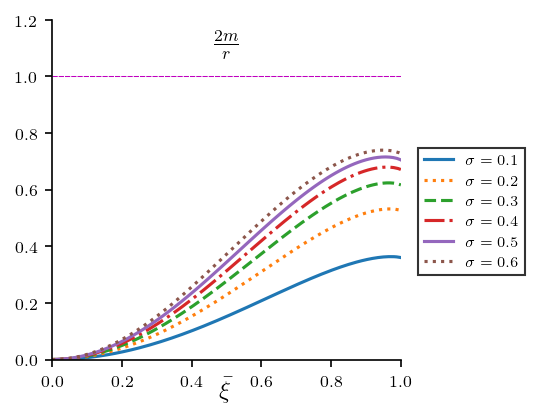

In [8]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(3,3),dpi=150)

for i in range(len(Lista_sigma)):

    ax1.plot(ListaModelos[i][0],ListaModelos[i][1],linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))

ax1.set_xbound(0.0,1.0)
ax1.set_ybound(0.0,1.2)
ax1.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax1.xaxis.set_label_coords(0.5, -0.05)
ax1.set_title(r'$\frac{2m}{r}$', x=0.5,y=0.85,fontsize=12)
ax1.legend(ncol=1, loc=(1.05,0.25),fontsize=7,edgecolor='k',fancybox=False)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.axhline(y=1.0,color='m',linestyle=(0,(5,1)),linewidth=0.5)

plt.show()

## * Condición C2: $\,\, \rho \geq 0$, $\,\,P \geq 0$, $\,\,P_{\perp} \geq 0$

La densidad de energía, presión radial y presión tangencial adimensionales son:
\begin{eqnarray}
     \frac{\rho}{\rho_{c}} &=& \left(1 - \sigma n \right) \hat{\psi}^{n} + \sigma n \hat{\psi}^{n+1} \,, \\
     \frac{P}{P_{c}} &=& \hat{\psi}^{n+1} \qquad \textrm{y} \\
     \frac{P_{\perp}}{P_{c}} &=& \frac{C \left(n+1 \right) \left(\eta + \sigma \xi^{3} \hat{\psi}^{n+1}  \right)}{\xi - 2 \sigma \left(n+1 \right) \eta} \left\{\left(1 - \sigma n \right) \hat{\psi}^{n} + \sigma (n+1) \hat{\psi}^{n+1} \right\} + \hat{\psi}^{n+1} \,,
\end{eqnarray}
respectivamente.

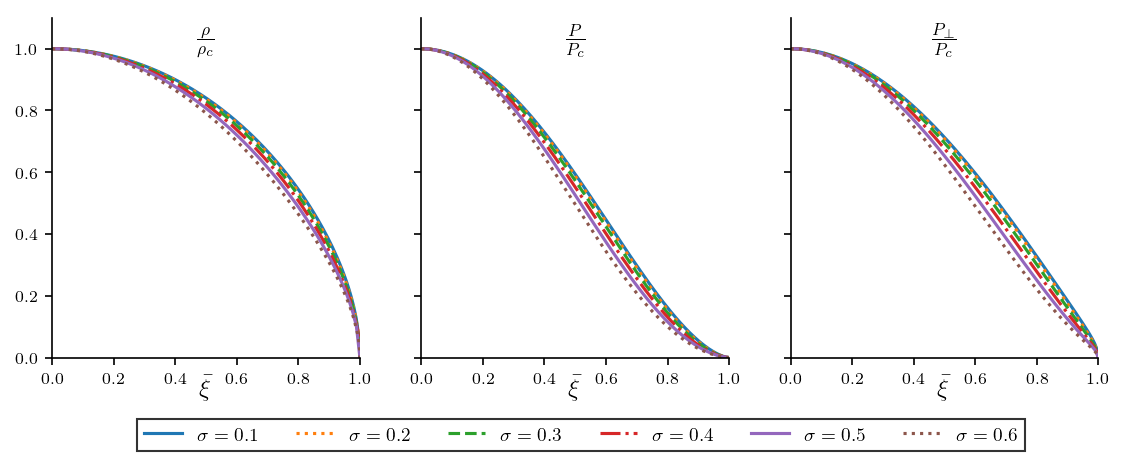

In [9]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3, sharey=True, figsize=(9,3),dpi=150)

for i in range(len(Lista_sigma)):
    
    ax1.plot(ListaModelos[i][0],ListaModelos[i][2][0],linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))
    ax2.plot(ListaModelos[i][0],ListaModelos[i][2][1],linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))
    ax3.plot(ListaModelos[i][0],ListaModelos[i][2][2],linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))

ax1.set_xbound(0.0,1.0)
ax1.set_ybound(0.0,1.1)
ax2.set_xbound(0.0,1.0)
ax3.set_xbound(0.0,1.0)
ax1.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax2.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax3.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax1.xaxis.set_label_coords(0.5, -0.05)
ax2.xaxis.set_label_coords(0.5, -0.05)
ax3.xaxis.set_label_coords(0.5, -0.05)
ax1.set_title(r'$\frac{\rho}{\rho_{c}}$', x=0.5,y=0.85,fontsize=12)
ax2.set_title(r'$\frac{P}{P_{c}}$', x=0.5,y=0.85,fontsize=12)
ax3.set_title(r'$\frac{P_{\perp}}{P_{c}}$', x=0.5,y=0.85,fontsize=12)
ax2.legend(ncol=len(Lista_sigma),loc=(0.5-0.475*len(Lista_sigma)/2,-0.275),edgecolor='k',fancybox=False,fontsize=9)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')

plt.show()

## * Condición C3: $\,\, \rho^{\prime} \leq 0$, $\,\,P^{\prime} \leq 0$, $\,\,P^{\prime}_{\perp} \leq 0$

Los gradientes de energía, de presión radial y de presión tangencial adimensionales son:
\begin{eqnarray}
    \frac{\dot{\rho}}{\rho_{c}} &=& n \left\{\left(1-\sigma n \right) \hat{\psi}^{n-1} + \sigma \left(n+1\right)\hat{\psi}^{n}\right\} \dot{\hat{\psi}} \,, \\
    \frac{\dot{P}}{P_{c}} &=& \left(n+1 \right) \hat{\psi}^{n} \dot{\hat{\psi}} \qquad \textrm{y} \\
    \frac{\dot{P}_{\perp}}{P_{c}} &=& \frac{C \sigma \left(n+1\right)}{\xi - 2\sigma\left(n+1\right)\eta} \Bigg\{ \hat{\psi}^{n-1} \dot{\hat{\psi}} \left\{n\left(1-\sigma n\right) + \sigma\left(n+1\right)^{2} \hat{\psi} \right\} \left(\eta + \sigma \xi^{3} \hat{\psi}^{n+1} \right)\Bigg.\nonumber \\
    && + \; \xi^{2} \hat{\psi}^{2n} \left\{1 - \sigma n + \sigma \left(n+1\right) \hat{\psi} \right\} \left\{1 - \sigma n + \sigma\left(n+3\right) \hat{\psi} + \sigma\left(n+1\right) \xi \dot{\hat{\psi}} \right\} \nonumber \\
     &&  - \; \Bigg. \frac{\hat{\psi}^{n} \left\{1 - \sigma n + \sigma \left(n+1\right) \hat{\psi}\right\} \left(\eta + \sigma \xi^{3} \hat{\psi}^{n+1} \right) \left\{1 - 2\sigma\left(n+1\right) \dot{\eta} \right\}}{\xi - 2\sigma\left(n+1\right)\eta}  \Bigg\} + \left(n+1 \right) \hat{\psi}^{n} \dot{\hat{\psi}} 
\end{eqnarray}
respectivamente.

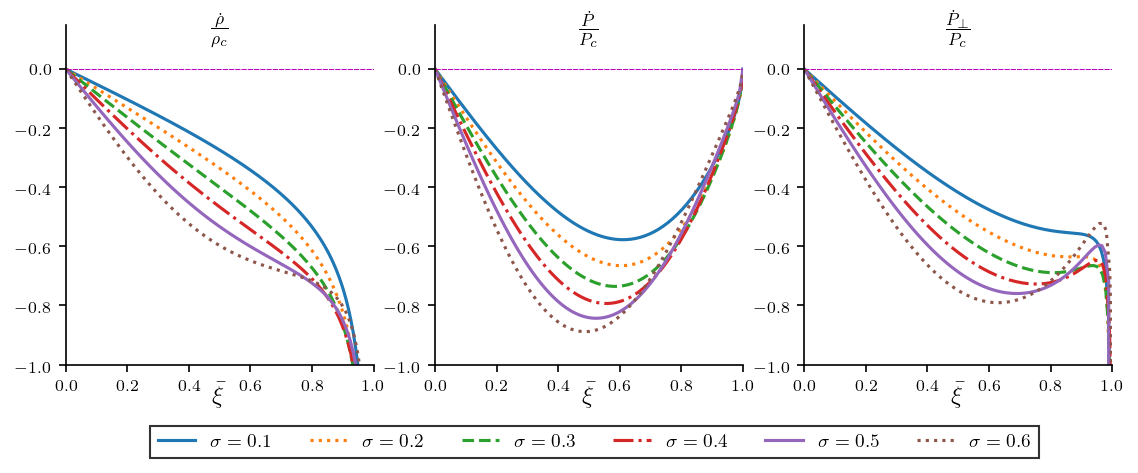

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3, figsize=(9,3),dpi=150)

for i in range(len(Lista_sigma)):
    
    ax1.plot(ListaModelos[i][0],ListaModelos[i][3][0],linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))
    ax2.plot(ListaModelos[i][0],ListaModelos[i][3][1],linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))
    ax3.plot(ListaModelos[i][0],ListaModelos[i][3][2],linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))
    
ax1.set_xbound(0.0,1.0)
ax1.set_ybound(-1.0,0.15)
ax2.set_xbound(0.0,1.0)
ax2.set_ybound(-1.0,0.15)
ax3.set_xbound(0.0,1.0)
ax3.set_ybound(-1.0,0.15)
ax1.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax2.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax3.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax1.xaxis.set_label_coords(0.5, -0.05)
ax2.xaxis.set_label_coords(0.5, -0.05)
ax3.xaxis.set_label_coords(0.5, -0.05)
ax1.set_title(r'$\frac{\dot{\rho}}{\rho_{c}}$', x=0.5,y=0.9,fontsize=12)
ax2.set_title(r'$\frac{\dot{P}}{P_{c}}$', x=0.5,y=0.9,fontsize=12)
ax3.set_title(r'$\frac{\dot{P}_{\perp}}{P_{c}}$', x=0.5,y=0.9,fontsize=12)
ax2.legend(ncol=len(Lista_sigma),loc=(0.5-0.475*len(Lista_sigma)/2,-0.275),edgecolor='k',fancybox=False,fontsize=9)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')
ax1.axhline(y=0.0,color='m',linestyle=(0,(5,1)),linewidth=0.5)
ax2.axhline(y=0.0,color='m',linestyle=(0,(5,1)),linewidth=0.5)
ax3.axhline(y=0.0,color='m',linestyle=(0,(5,1)),linewidth=0.5)

plt.show()

## * Condición C4: $\,\, \rho - P - 2 P_{\perp} \geq 0$

La condición sobre la traza del tensor energía-momento es
\begin{equation}
    \left\{\left(1/\sigma \right) - n \right\} \hat{\psi}^{n} + n \hat{\psi}^{n+1} - 3 \hat{\psi}^{n+1} - \frac{2C(n+1)\left(\eta + \sigma \xi^{3} \hat{\psi}^{n+1} \right)}{\xi - 2 \sigma (n+1) \eta} \left\{(1 - \sigma n) \hat{\psi}^{n} + \sigma (n+1) \hat{\psi}^{n+1} \right\} 
\end{equation}

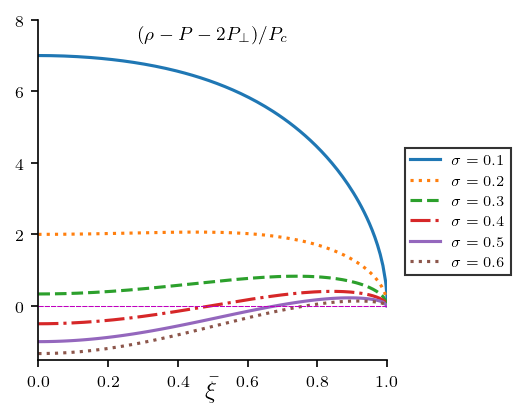

In [11]:
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(3,3),dpi=150)

for i in range(len(Lista_sigma)):
    
    ax1.plot(ListaModelos[i][0],ListaModelos[i][4],linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))

ax1.set_xbound(0.0,1.0)
ax1.set_ybound(-1.5,8)
ax1.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax1.xaxis.set_label_coords(0.5, -0.05)
ax1.set_title(r'$(\rho - P - 2P_{\perp})/P_{c}$', x=0.5,y=0.9,fontsize=9)
ax1.legend(ncol=1, loc=(1.05,0.25),fontsize=7,edgecolor='k',fancybox=False)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.axhline(y=0,color='m',linestyle=(0,(5,1)),linewidth=0.5)

plt.show()

## * Condición C5: $\,\, 0 < v_{s}^{2} \leq 1 \,\, $ y $\,\,0 < v_{s \perp}^{2} \leq 1$

Las velocidades del sonido radial y tangencial, adimensionales, son
\begin{eqnarray}
    v^{2}_{s} &=& \frac{\sigma \left(n+1\right) \hat{\psi}}{n\left\{1 - \sigma n + \sigma (n+1) \hat{\psi} \right\}} \qquad \textrm{y} \\
    v^{2}_{s \perp} &=& \frac{C \sigma\left(n+1\right)}{\xi -2\sigma\left(n+1\right)\eta} \Bigg\{ \left(1 + v^{2}_{s} \right) \left( \eta + \sigma \xi^{3}\hat{\psi}^{n+1} \right) + \frac{\xi^{2} \hat{\psi}^{n+1} \left\{1 - \sigma n + \sigma \left(n+3\right) \hat{\psi} + \sigma \left(n+1\right) \xi \dot{\hat{\psi}} \right\}}{n \dot{\hat{\psi}}} - \left. \frac{\hat{\psi} \left(\eta + \sigma \xi^{3} \hat{\psi}^{n+1} \right) \left\{ 1 - 2 \sigma \left(n+1\right) \xi^{2} \hat{\psi}^{n} \left(1 - \sigma n + \sigma n \hat{\psi}\right) \right\}}{n \dot{\hat{\psi}} \left\{\xi - 2 \sigma \left(n+1\right) \eta \right\}} \right\} + v^{2}_{s} \,,
\end{eqnarray}
respectivamente.

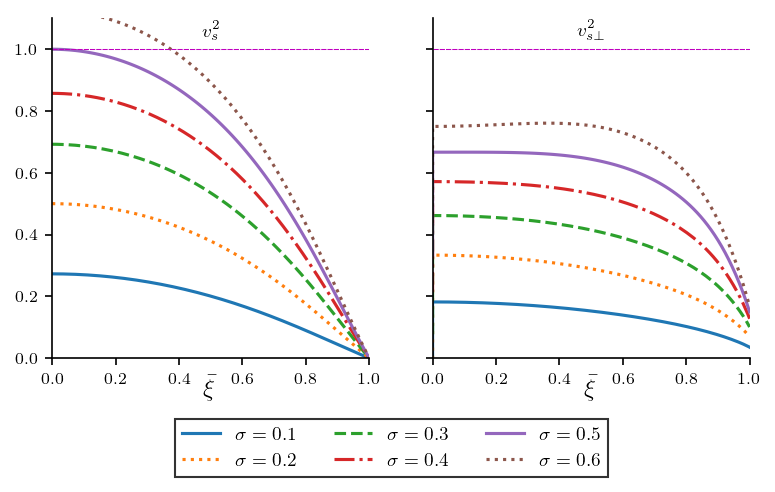

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(6,3),dpi=150)

for i in range(len(Lista_sigma)):
    
    ax1.plot(ListaModelos[i][0],ListaModelos[i][5][0],linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))
    ax2.plot(ListaModelos[i][0],ListaModelos[i][5][1],linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))

ax1.set_xbound(0.0,1.0)
ax1.set_ybound(0.0,1.1)
ax2.set_xbound(0.0,1.0)
ax1.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax2.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax1.xaxis.set_label_coords(0.5, -0.05)
ax2.xaxis.set_label_coords(0.5, -0.05)
ax1.set_title(r'$v^{2}_{s}$', x=0.5,y=0.9,fontsize=9)
ax2.set_title(r'$v^{2}_{s \perp}$', x=0.5,y=0.9,fontsize=9)
ax2.legend(ncol=len(Lista_sigma)//2, loc=(-0.1-0.475*len(Lista_sigma)/4,-0.35),edgecolor='k',fancybox=False,fontsize=9)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax1.axhline(y=1.0,color='m',linestyle=(0,(5,1)),linewidth=0.5)
ax2.axhline(y=1.0,color='m',linestyle=(0,(5,1)),linewidth=0.5)

plt.show()

## * Condición C6: $\,\, \Gamma \leq \frac{4}{3}$

El índice adiabático es
\begin{equation}
    \Gamma \equiv \frac{n+1}{n}
\end{equation}

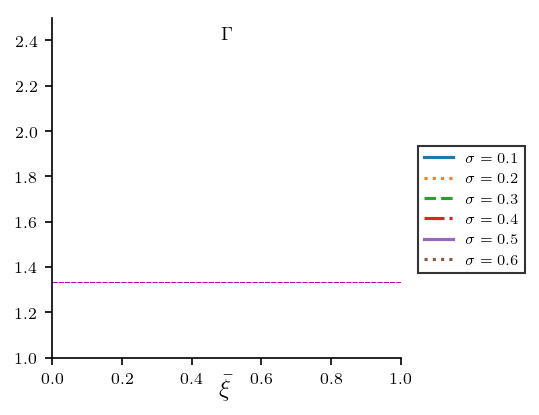

In [13]:
fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(3,3),dpi=150)

for i in range(len(Lista_sigma)):
    
    ax1.plot(ListaModelos[i][0],ListaModelos[i][6],linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))

ax1.set_xbound(0.0,1.0)
ax1.set_ybound(1.0,2.5)
ax1.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax1.xaxis.set_label_coords(0.5, -0.05)
ax1.set_title(r'$\Gamma$', x=0.5,y=0.9,fontsize=9)
ax1.legend(ncol=1, loc=(1.05,0.25),fontsize=7,edgecolor='k',fancybox=False)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.axhline(y=4/3,color='m',linestyle=(0,(5,1)),linewidth=0.5)

plt.show()

## * Condición C7: $\,\, \frac{\mathrm{d}M(\rho_{c})}{\mathrm{d}\rho_{c}} > 0$

Esta condición requiere de la variación del parámetro $\sigma$, por lo tanto se ha realizado aparte en [Condición C7](https://github.com/danielfsu/TrabajoDeInvestigacion/blob/main/Pol%C3%ADtropa_I_%28Densidad_de_Masa%29/Pol%C3%ADtropa%20I%20-%20C7.ipynb).

## * Condición C8: Cambio de signo en la ecuación de equilibrio perturbada

La ecuación de equilibrio perturbada está dada por
\begin{equation}
    \frac{\delta \mathcal{R}}{\delta \rho} = \underbrace{\frac{h \left(m + 4 \pi r^{3} P \right)}{r(r-2m)}}_{\mathcal{R}_{1}}  + \underbrace{\frac{h \left(\rho + P \right) \left(1 + 8 \pi P r^{2} \right)}{\left(r - 2m \right)^{2}} \, \frac{4 \pi r^{2} \rho}{\rho^{\prime}}}_{\mathcal{R}_{2}} + \underbrace{\frac{h \left\{m + 4 \pi r^{3} \left(\rho + 2 P \right) \right\}}{r(r-2m)} v^{2}}_{\mathcal{R}_{3}}  + \underbrace{\left\{\left(v^{2} \right)^{\prime} + v^{2} \frac{\rho^{\prime \prime}}{\rho^{\prime}} \right\}}_{\mathcal{R}_{4}} \,.
\end{equation}

Por lo tanto, la ecuación de equilibrio hidrostático perturbada adimensional es
\begin{eqnarray}
a \frac{\delta \mathcal{R}}{\delta \rho} &\equiv& \frac{h \sigma \left(n+1 \right) \left(\eta + \sigma \xi^{3} \hat{\psi}^{n+1}\right)}{\xi \left\{\xi - 2 \sigma\left(n+1 \right) \eta \right\}} + \frac{h\left\{ \left(1 - n \sigma \right) \hat{\psi}^{n} + \sigma \left( n+1 \right) \hat{\psi}^{n+1} \right\} \left\{1 + 2 \sigma^{2} \xi^{2}(n+1) \hat{\psi}^{n+1} \right\}}{ \left\{\xi - 2 \sigma\left(n+1 \right) \eta \right\}^{2}} \times \frac{\sigma \xi^{2} \left( n+1 \right) \left\{ \left( 1 - \sigma n \right) \hat{\psi}^{n} + \sigma n  \hat{\psi}^{n+1} \right\}}{n \hat{\psi}^{n-1} \dot{\hat{\psi}} \left\{(1 - \sigma n) + \sigma (n+1) \hat{\psi} \right\} } \nonumber \\ && + \frac{h \sigma^{2} (n + 1)^{2} \hat{\psi} \left\{\eta + \xi^{3} \left( 1 - \sigma n \right)  \hat{\psi}^{n} + \sigma \xi^{3} \left( n+2 \right) \hat{\psi}^{n + 1}) \right\}}{n \xi \left\{\xi - 2 \sigma (n+1) \eta \right\} \left\{\left( 1 - n \sigma \right) + \sigma \left( n+1 \right) \hat{\psi} \right\}} + \frac{\sigma (n + 1) \left\{ \hat{\psi}^{n} \ddot{\hat{\psi}} + n \hat{\psi}^{n-1} \left(\dot{\hat{\psi}} \right)^{2} \right\}}{n \hat{\psi}^{n-1} \dot{\hat{\psi}} \left\{(1 - \sigma n) + \sigma (n+1) \hat{\psi} \right\}} =  \bar{\mathcal{R}}
\end{eqnarray}


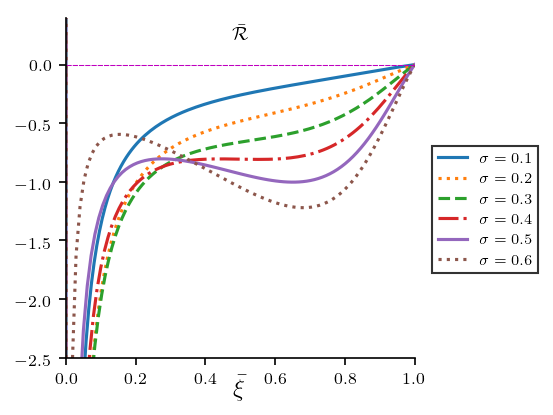

In [14]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(3,3),dpi=150)

for i in range(len(Lista_sigma)):
    
    ax1.plot(ListaModelos[i][0],ListaModelos[i][8],linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))

ax1.set_xbound(0.0,1.0)
ax1.set_ybound(-2.5,0.4)
ax1.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax1.xaxis.set_label_coords(0.5, -0.05)
ax1.set_title(r'$\bar{\mathcal{R}}$', x=0.5,y=0.9,fontsize=9)
ax1.legend(ncol=1, loc=(1.05,0.25),fontsize=7,edgecolor='k',fancybox=False)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.axhline(y=0,color='m',linestyle=(0,(5,1)),linewidth=0.5)

plt.show()

## * Condición C9: $\,\, \rho^{\prime \prime} \leq 0$

La segunda derivada de la densidad de energía adimensional es
\begin{equation}
    \ddot{\left(\Psi^{n}\right)} = n \left\{\left(n-1 \right) \hat{\psi}^{n-2} \left(\dot{\hat{\psi}} \right)^{2} + \hat{\psi}^{n-1} \ddot{\hat{\psi}} \right\}
\end{equation}

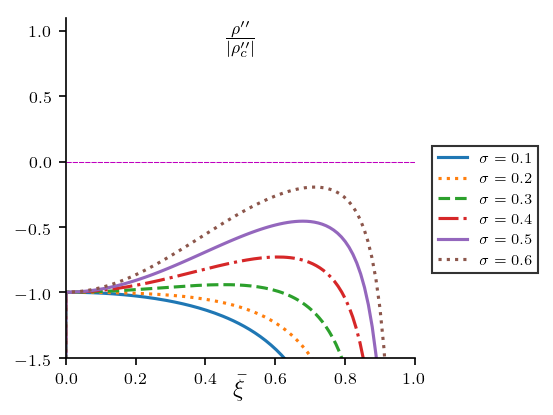

In [15]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(3,3),dpi=150)

for i in range(len(Lista_sigma)):
    
    ax1.plot(ListaModelos[i][0],ListaModelos[i][9]/abs(ListaModelos[i][9][1]),linestyle=LineStyles[i],label=r'$\sigma = %.1f$'%(Lista_sigma[i]))
    
ax1.set_xbound(0.0,1.0)
ax1.set_ybound(-1.5,1.1)
ax1.set_xlabel(r'$\bar{\xi}$',fontsize=12)
ax1.xaxis.set_label_coords(0.5, -0.05)
ax1.set_title(r'$\frac{\rho^{\prime \prime}}{|\rho^{\prime \prime}_{c}|}$', x=0.5,y=0.85,fontsize=12)
ax1.legend(ncol=1, loc=(1.05,0.25),fontsize=7,edgecolor='k',fancybox=False)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.axhline(y=0,color='m',linestyle=(0,(5,1)),linewidth=0.5)

plt.show()